In [32]:
%load_ext autoreload
%autoreload 2

import scipy
import numpy as np
import matplotlib.pyplot as plt
import keras
# use torch backend
import torch

import time




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Observations
At each timestep $t$, we observe $S=1$ artificial locations. The observed value $y_{s,t}$ is realization of random variable $Y_s$, which is normally distributed with unit variance and a location-specific mean: $Y_{s,t} \sim \mathcal{N}(\mu_s, 1)$. The mean is $\mu = [0]$.

In [2]:
# Distribution Settings
scale = 1
mean = 0

normal_dist = scipy.stats.norm(loc=mean, scale=scale)

# Number of independent datapoints 
T = 1000

seed=360
rng = np.random.RandomState(seed)
y_T = torch.Tensor(normal_dist.rvs(size=T, random_state=rng))
y_T.requires_grad_(True)
# supress cell output
''''''

''

In total, we observe $T=1000$ examples. We frame this as a machine learning problem and our goal is to train a model to accurately predict $y$.

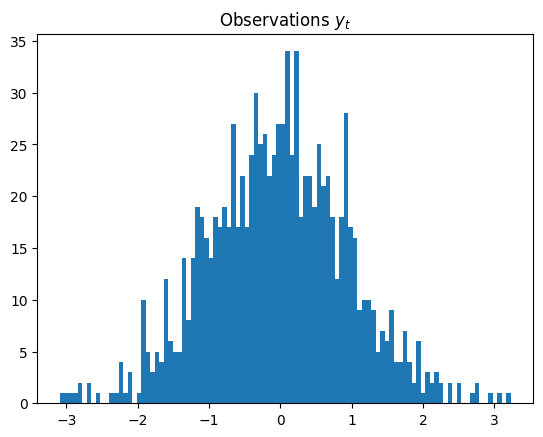

In [33]:
plt.hist(y_T.detach().numpy(), bins=100)
plt.title("Observations $y_t$")
plt.show()

## Model
We will model this with the true model: predictions $\hat{y}_{s,t}$ will come from S, location-specific normal distributions, where the mean is determined by a function $f_{\phi_s}(y)=\phi_s$ with location-specific parameter $\phi_s$, and the variance is fixed to the true value of 1.

$$p(\hat{y}_{s,t}) = \mathcal{N}(\hat{y}_{s,t}| \phi_s, 1)$$
All locations are independent:
$$p(\hat{y}_{t}) = \prod_{s=1}^S \mathcal{N}(\hat{y}_{s,t}| \phi_s, 1)$$


Our model can trivially recover the true data generating process by setting the parameter to the true mean $\phi_s = \mu_s$

## Objective
We will use our model's predictions $\hat{y}$ in order to choose some action $r$, which can be calculated by a deterministic but not necessarily differentiable function $a$ of $\hat{y}$:
$$r_t = \frac{1}{M}\sum_m f(\hat{y}_t)$$

Given a decision $r$, we can calculate a loss between our action and the observed outcome $\mathcal{L}(r_t, y_t)$. Our goal is to calculate gradients of that loss with respect to our model parameters. We can use the chain rule to decompose the gradient into two parts:
$$ \nabla_\phi \mathcal{L}(r_t, y_t) = \nabla_\phi r \nabla_r  \mathcal{L}(r_t, y_t)$$

When $r$ is non-differentiable, we can obtain gradients using the score-function trick, where we can approximate the gradient using $M$ samples from our probabilistic model $p$
$$\nabla_\phi r = \frac{1}{M} \sum_{m=1}^M \nabla_\phi \log p(\hat{y}_t^m) f(\hat{y}_t^m)$$

Our loss is mean-squared error and easy to differentiate: 
$$\mathcal{L} (r_t, y_t) = \frac{1}{S}\sum_{s=1}^S(y_t-r_t)^2$$

### Differentiate the score function trick
We'll take $M=5$ samples, and use the identity function as our action $a(y)=y$
$$ \nabla_\phi \mathcal{L}(r_t, y_t) = \nabla_\phi r \nabla_r  \mathcal{L}(r_t, y_t)$$

When $r$ is non-differentiable, we can obtain gradients using the score-function trick, where we can approximate the gradient using $M$ samples from our probabilistic model $p$
$$\nabla_\phi r = \frac{1}{M} \sum_{m=1}^M \nabla_\phi \log p(y^m) a(y)$$

Our loss is mean-squared error and easy to differentiate: 
$$\mathcal{L} (r_t, y_t) = \frac{1}{S}\sum_{s=1}^S(y_t-r_t)^2$$
$$\nabla_\phi \log p(y^m) = \nabla_\phi \left( -\log (\sigma) - \frac{1}{2}\log (2\pi) - \frac{1}{2}(\frac{y^m-\phi_\mu}{\sigma})^2 \right)$$
$$ \nabla_\phi \log p(y^m) = \frac{y^m-\phi_\mu}{\sigma^2} = y^m -\phi_\mu$$
$$\nabla_\phi r = \frac{1}{M} \sum_{m=1}^M (y^m - \phi_\mu) a(y)$$
 $$\nabla_r  \mathcal{L}(r_t, y_t) =  \nabla_r   \frac{1}{S}\sum_{s=1}^S(y_t-r_t)^2$$
 $$ = \frac{1}{S}\sum_{s=1}^S-2(y_t-r_t)$$

In [36]:
M = 2

start = time.time()

vals, losses, anal_grad_r, numer_grad_r, anal_grad_L, numer_grad_L, anal_grad, numer_grad = [], [], [], [], [], [], [], []

for param_value in np.linspace(-5, 5, 11, dtype=np.float32):

    param = torch.tensor([param_value], requires_grad=True)
    print(param_value)

    for trial in range(100):
        if trial % 500 ==0:
            print(trial)

        # Get some samples from the implied distribution
        param_sized = param*torch.ones(T)
        distribution = torch.distributions.Normal(loc=param_sized, scale=1)
        samples_MT = distribution.sample(sample_shape=(M,))

        # calculate the log prob of those samples
        # log probs cannot be an argument, must be "baked" into function
        def get_log_probs_baked(param):
            param_sized = param*torch.ones(T)
            distribution = torch.distributions.Normal(loc=param_sized, scale=1)
            log_probs_MT = distribution.log_prob(samples_MT)

            return log_probs_MT
        
        analytical_grad_r_wrt_phi_MT = (samples_MT -param)*samples_MT
        jac_log_prob_MT = torch.autograd.functional.jacobian(get_log_probs_baked, (param), strategy='forward-mode', vectorize=True)
        autodiff_grad_r_wrt_phi_MT = jac_log_prob_MT * torch.unsqueeze(samples_MT, dim=-1)
        analytical_grad_r_wrt_phi_T = torch.mean(analytical_grad_r_wrt_phi_MT, dim=0)
        autodiff_grad_r_wrt_phi_T = torch.mean(autodiff_grad_r_wrt_phi_MT, dim=0)

        action_samples_MT = samples_MT#distribution.sample(sample_shape=(M,))
        expected_action_T = torch.mean(action_samples_MT, dim=0)
        expected_action_T.requires_grad_(True)
        # ge
        loss_T = torch.nn.functional.mse_loss(expected_action_T, y_T)
        # grad is sign of y_t
        #analytical_grad_L_wrt_r_T = -torch.sign(y_T-expected_action_T) 
        analytical_grad_L_wrt_r_T = -2.0*(y_T - expected_action_T)
        loss_T.backward()
        autodiff_grad_L_wrt_r_T = expected_action_T.grad

        analytical_grad_T = analytical_grad_r_wrt_phi_T * torch.unsqueeze(analytical_grad_L_wrt_r_T, 1)
        autodiff_grad_T = autodiff_grad_r_wrt_phi_T * torch.unsqueeze(autodiff_grad_L_wrt_r_T, 1)

        vals.append(param_value)
        losses.append(loss_T.detach().numpy())
        anal_grad_r.append(analytical_grad_r_wrt_phi_T.detach().numpy())
        numer_grad_r.append(autodiff_grad_r_wrt_phi_T.detach().numpy())
        anal_grad_L.append(analytical_grad_L_wrt_r_T.detach().numpy())
        numer_grad_L.append(autodiff_grad_L_wrt_r_T.detach().numpy())
        anal_grad.append(analytical_grad_T.detach().numpy())
        numer_grad.append(autodiff_grad_T.detach().numpy())

end = time.time()
elapsed = end - start

-5.0
0
-4.0
0
-3.0
0
-2.0
0
-1.0
0
0.0
0
1.0
0
2.0
0
3.0
0
4.0
0
5.0
0


Text(0.5, 1.0, '$\\nabla_\\phi \\mathcal{L}$, M=2,time: 2.65s')

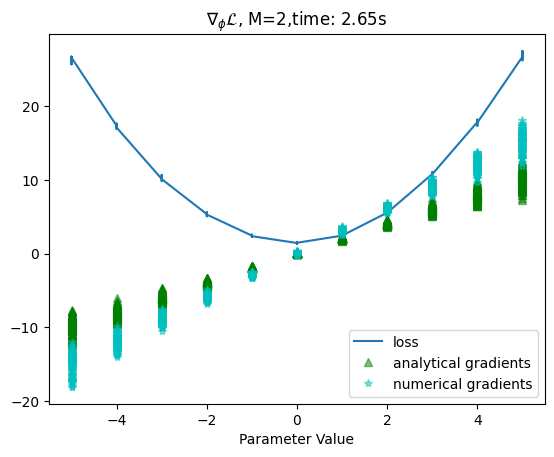

In [37]:
fig, ax1 = plt.subplots()
ax1.set_xlabel('Parameter Value')
ax1.plot(vals, losses, label='loss')

ax1.plot(vals, [np.mean(grad) for grad in anal_grad], 'g^',alpha=0.5, label='analytical gradients')
ax1.plot(vals, [np.sum(grad) for grad in numer_grad], 'c*',alpha=0.5, label='numerical gradients')
plt.legend()
plt.title(r'$\nabla_\phi \mathcal{L}$, '+f'M={M},time: {elapsed:.2f}s')

(0.0, 5.0)

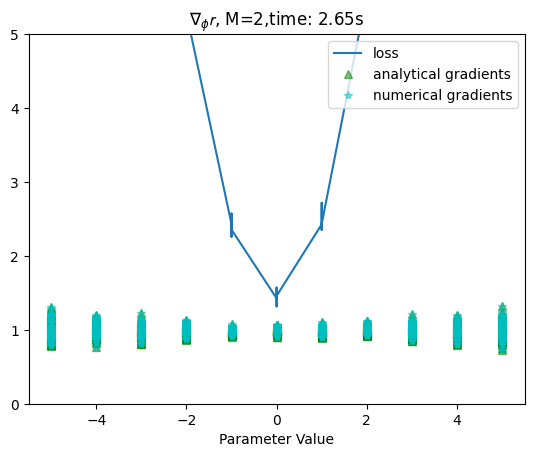

In [40]:
fig, ax1 = plt.subplots()
ax1.set_xlabel('Parameter Value')
ax1.plot(vals, losses, label='loss')

ax1.plot(vals, [np.mean(grad) for grad in anal_grad_r], 'g^', label='analytical gradients', alpha=0.5)
ax1.plot(vals, [np.mean(grad) for grad in numer_grad_r], 'c*', label='numerical gradients', alpha=0.5)
plt.legend()
plt.title(r'$\nabla_\phi \mathcal{r}$, '+f'M={M},time: {elapsed:.2f}s')
plt.ylim([0,5])

Text(0.5, 1.0, '$\\nabla_r \\mathcal{L}$, M=2,time: 2.65s')

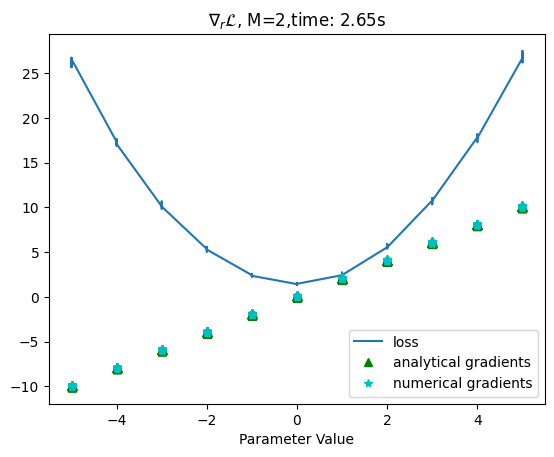

In [41]:
fig, ax1 = plt.subplots()
ax1.set_xlabel('Parameter Value')
ax1.plot(vals, losses, label='loss')

ax1.plot(vals, [np.mean(grad) for grad in anal_grad_L], 'g^', label='analytical gradients')
ax1.plot(vals, [np.sum(grad) for grad in numer_grad_L], 'c*', label='numerical gradients')
plt.legend()
plt.title(r'$\nabla_r \mathcal{L}$, '+f'M={M},time: {elapsed:.2f}s')

Text(0.5, 1.0, '$\\nabla_\\theta \\mathcal{L}$, M=10000,time: 55.68s')

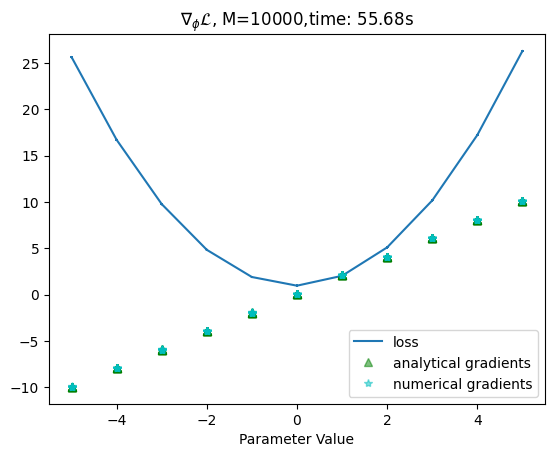

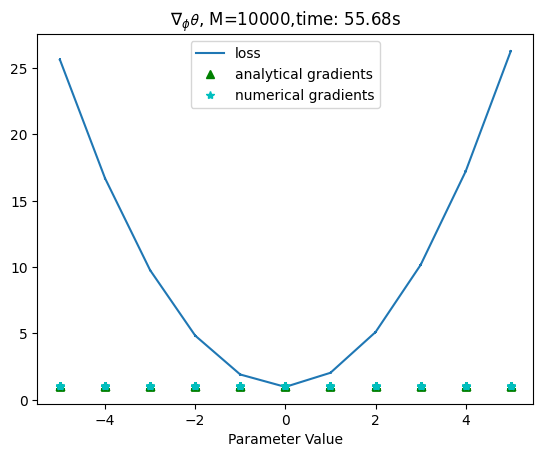

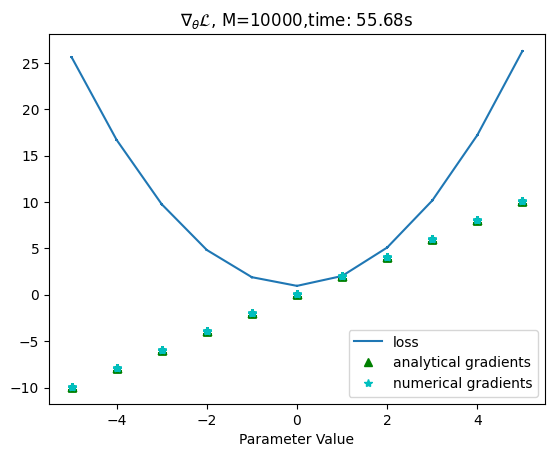

In [128]:
fig, ax1 = plt.subplots()
ax1.set_xlabel('Parameter Value')
ax1.plot(vals, losses, label='loss')

ax1.plot(vals, [np.mean(grad) for grad in anal_grad], 'g^',alpha=0.5, label='analytical gradients')
ax1.plot(vals, [np.sum(grad) for grad in numer_grad], 'c*',alpha=0.5, label='numerical gradients')
plt.legend()
plt.title(r'$\nabla_\phi \mathcal{L}$, '+f'M={M},time: {elapsed:.2f}s')

fig, ax1 = plt.subplots()
ax1.set_xlabel('Parameter Value')
ax1.plot(vals, losses, label='loss')

ax1.plot(vals, [np.mean(grad) for grad in anal_grad_r], 'g^', label='analytical gradients')
ax1.plot(vals, [np.mean(grad) for grad in numer_grad_r], 'c*', label='numerical gradients')
plt.legend()
plt.title(r'$\nabla_\phi \mathcal{r}$, '+f'M={M},time: {elapsed:.2f}s')

fig, ax1 = plt.subplots()
ax1.set_xlabel('Parameter Value')
ax1.plot(vals, losses, label='loss')

ax1.plot(vals, [np.mean(grad) for grad in anal_grad_L], 'g^', label='analytical gradients')
ax1.plot(vals, [np.sum(grad) for grad in numer_grad_L], 'c*', label='numerical gradients')
plt.legend()
plt.title(r'$\nabla_r \mathcal{L}$, '+f'M={M},time: {elapsed:.2f}s')


In [50]:
[np.mean(grad) for grad in numer_grad]

[0.00018617946,
 -0.00027258732,
 -5.2011237e-06,
 0.00018365102,
 0.000123873,
 0.00013241598,
 -2.3332432e-05,
 0.000257431,
 0.0005547508,
 2.5422756e-05,
 5.502917e-05,
 4.058681e-05,
 -8.9222354e-05,
 4.7139165e-05,
 -8.102873e-05,
 -0.00038875663,
 0.00058035814,
 -0.000119333075,
 0.0001392584,
 8.97855e-05,
 4.1955376e-05,
 -0.00018266427,
 -4.806988e-05,
 2.6495443e-05,
 -7.832831e-05,
 -0.0001801407,
 -3.772761e-05,
 -5.5536686e-05,
 8.851932e-05,
 3.5748806e-05,
 -0.00016392716,
 4.1696196e-05,
 5.5270284e-05,
 6.95133e-05,
 -0.0001422174,
 3.8993287e-05,
 2.7167164e-06,
 9.310095e-05,
 -1.5208155e-05,
 -1.797727e-05,
 -0.00013850893,
 -9.623717e-05,
 -3.123299e-05,
 5.0106577e-05,
 -4.6711626e-05,
 4.157176e-05,
 -3.8398033e-05,
 0.00018139397,
 -1.8739813e-05,
 -9.026251e-05,
 -3.056829e-05,
 -1.7068262e-05,
 -1.4013566e-05,
 3.957633e-05,
 8.110906e-05,
 -7.5455087e-06,
 -2.4022564e-05,
 -4.279674e-05,
 -4.1547206e-05,
 3.330332e-05,
 2.0290267e-05,
 8.44038e-05,
 -5.5854

In [51]:
[np.mean(grad) for grad in numer_grad_r]

[-0.019893425,
 0.024868539,
 0.00409787,
 -0.017555978,
 -0.011278702,
 -0.0072144833,
 0.005025932,
 -0.018429825,
 -0.058510024,
 0.009745349,
 -0.0074980143,
 -0.013480158,
 0.0074054548,
 0.0022459335,
 0.004421507,
 0.046300508,
 -0.06101053,
 0.014492712,
 -0.009784353,
 -0.014391062,
 -0.0030888782,
 0.028707817,
 0.0029996757,
 -0.003252427,
 0.011040169,
 0.026075587,
 0.011770829,
 0.006976722,
 -0.016736457,
 0.0043304074,
 0.023487004,
 -0.01060179,
 -0.019311331,
 -0.025998836,
 0.035514113,
 0.0009665928,
 0.007890291,
 -0.030522019,
 -0.0038923903,
 -0.008654033,
 0.016917644,
 2.8090477e-05,
 0.024836106,
 -0.0510255,
 0.0026977253,
 -0.022508984,
 0.024374837,
 -0.070717394,
 0.003299064,
 -0.007853807,
 -0.017073784,
 -0.0369885,
 -0.01758736,
 -0.0206553,
 -0.024274934,
 -0.01278419,
 -0.032421265,
 -0.043887947,
 -0.007343233,
 -0.021382317,
 0.014731523,
 0.03125373,
 -0.023854226,
 -0.019992119,
 0.0017599848,
 0.017516369,
 0.0069587673,
 -0.008510141,
 -0.00588